In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
# !pip install catboost

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import json
import numpy as np
import pandas as pd

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from catboost import Pool, CatBoostClassifier

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

2025-04-17 17:50:17.376 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /home/onyxia/work/QRT-Challenge-2024


In [4]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [5]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [6]:
train_data.shape

(12303, 956)

In [7]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores_1c, train_size=0.8, random_state=42)

In [9]:
space = {
    # analogous to n_estimators
    'iterations':            hp.quniform('iterations', 100, 2000, 50),

    # tree depth (max_depth)
    'depth':                 hp.quniform('depth', 3, 10, 1),

    # learning rate (shrinkage)
    'learning_rate':         hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),

    # L2 regularization (reg_lambda)
    'l2_leaf_reg':           hp.uniform('l2_leaf_reg', 1.0, 10.0),

    # “feature_fraction” → random subspace method
    'rsm':                   hp.uniform('rsm', 0.2, 0.8),

    # bagging (used instead of bootstrap + min_samples_split)
    'bagging_temperature':   hp.uniform('bagging_temperature', 0.0, 1.0),

    # how many bins to use for numeric features
    'border_count':          hp.quniform('border_count', 32, 255, 32),

    # random noise in score calculation (like random_state)
    'random_strength':       hp.uniform('random_strength', 0.0, 10.0),

    # tree growth strategy
    'grow_policy':           hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),

    # class weights (None or Balanced)
    'auto_class_weights':    hp.choice('auto_class_weights', [None, 'Balanced']),
}


In [10]:
n_splits = 3

def objective(params):
    for int_param in ('iterations', 'depth', 'border_count'):
        if int_param in params:
            params[int_param] = int(params[int_param])
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, valid_index in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        model = CatBoostClassifier(
            loss_function='MultiClass',
            eval_metric='MultiClass',
            verbose=False,
            thread_count=-1,
            random_seed=42,
            **params
        )        
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_valid_fold)
        accuracy = accuracy_score(y_valid_fold, y_pred)
        accuracies.append(accuracy)

    mean_loss = 1 - np.mean(accuracies)
    return {'loss': mean_loss, 'status': STATUS_OK}

In [11]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150, 
            trials=trials)

print("Best hyperparameters:", best)

  0%|          | 0/150 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 150/150 [8:08:31<00:00, 195.41s/trial, best loss: 0.5022345953419911]  
Best hyperparameters: {'auto_class_weights': np.int64(0), 'bagging_temperature': np.float64(0.7204644511740705), 'border_count': np.float64(96.0), 'depth': np.float64(10.0), 'grow_policy': np.int64(2), 'iterations': np.float64(400.0), 'l2_leaf_reg': np.float64(3.9260591734721277), 'learning_rate': np.float64(0.024641842717202437), 'random_strength': np.float64(6.544828582681004), 'rsm': np.float64(0.6208373548691649)}


In [12]:
# Convert NumPy types to native Python types for JSON serialization
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)  
    elif isinstance(obj, np.floating):
        return float(obj)  
    elif isinstance(obj, list):  
        return [convert_numpy(i) for i in obj]  
    elif isinstance(obj, dict):  
        return {key: convert_numpy(value) for key, value in obj.items()}  
    else:
        return obj

results_with_params = [
    {
        **convert_numpy(trial['result']),
        'params': {key: convert_numpy(value[0]) if value else None for key, value in trial['misc']['vals'].items()}  # Convert hyperparameters
    }
    for trial in trials.trials
]

with open('catboost_model.json', 'w') as f:
    json.dump(results_with_params, f, indent=4)

print("Optimization results saved to 'catboost_model.json'")


Optimization results saved to 'catboost_model.json'


In [13]:
with open("catboost_model.json", "r") as f:
    results_with_params = json.load(f)

print("\nBest trial")
best_trial = min(results_with_params, key=lambda x: x["loss"])
print("Best hyperparameters:", best_trial["params"])
print("Best loss:", best_trial["loss"])


Best trial
Best hyperparameters: {'auto_class_weights': 0, 'bagging_temperature': 0.7204644511740705, 'border_count': 96.0, 'depth': 10.0, 'grow_policy': 2, 'iterations': 400.0, 'l2_leaf_reg': 3.9260591734721277, 'learning_rate': 0.024641842717202437, 'random_strength': 6.544828582681004, 'rsm': 0.6208373548691649}
Best loss: 0.5022345953419911


In [14]:
best_params = best_trial['params']

# Cast integer‐only hyperparameters
for int_param in ('iterations', 'depth', 'border_count'):
    if int_param in best_params:
        best_params[int_param] = int(best_params[int_param])

# Map grow_policy index → string
grow_policy_options = ['SymmetricTree', 'Depthwise', 'Lossguide']
gp = best_params.get('grow_policy')
if isinstance(gp, (int, np.integer)):
    best_params['grow_policy'] = grow_policy_options[int(gp)]

# Map auto_class_weights index → None or 'Balanced'
auto_weights_options = [None, 'Balanced']
aw = best_params.get('auto_class_weights')
if isinstance(aw, (int, np.integer)):
    best_params['auto_class_weights'] = auto_weights_options[int(aw)]

In [15]:
final_model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='MultiClass',
    verbose=False,
    thread_count=-1,
    random_seed=42,
    **best_params
)        
final_model.fit(X_train, y_train)

In [16]:
y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy (test) : {final_accuracy * 100:.2f}%")

Accuracy (test) : 49.90%


In [17]:
importance_dict = dict(zip(
    X_train.columns,
    final_model.feature_importances_
))

sorted_features = sorted(
    importance_dict.items(),
    key=lambda x: x[1],
    reverse=True
)
top_features = [feature for feature, score in sorted_features[:10]]

X_reduced = train_data[top_features]

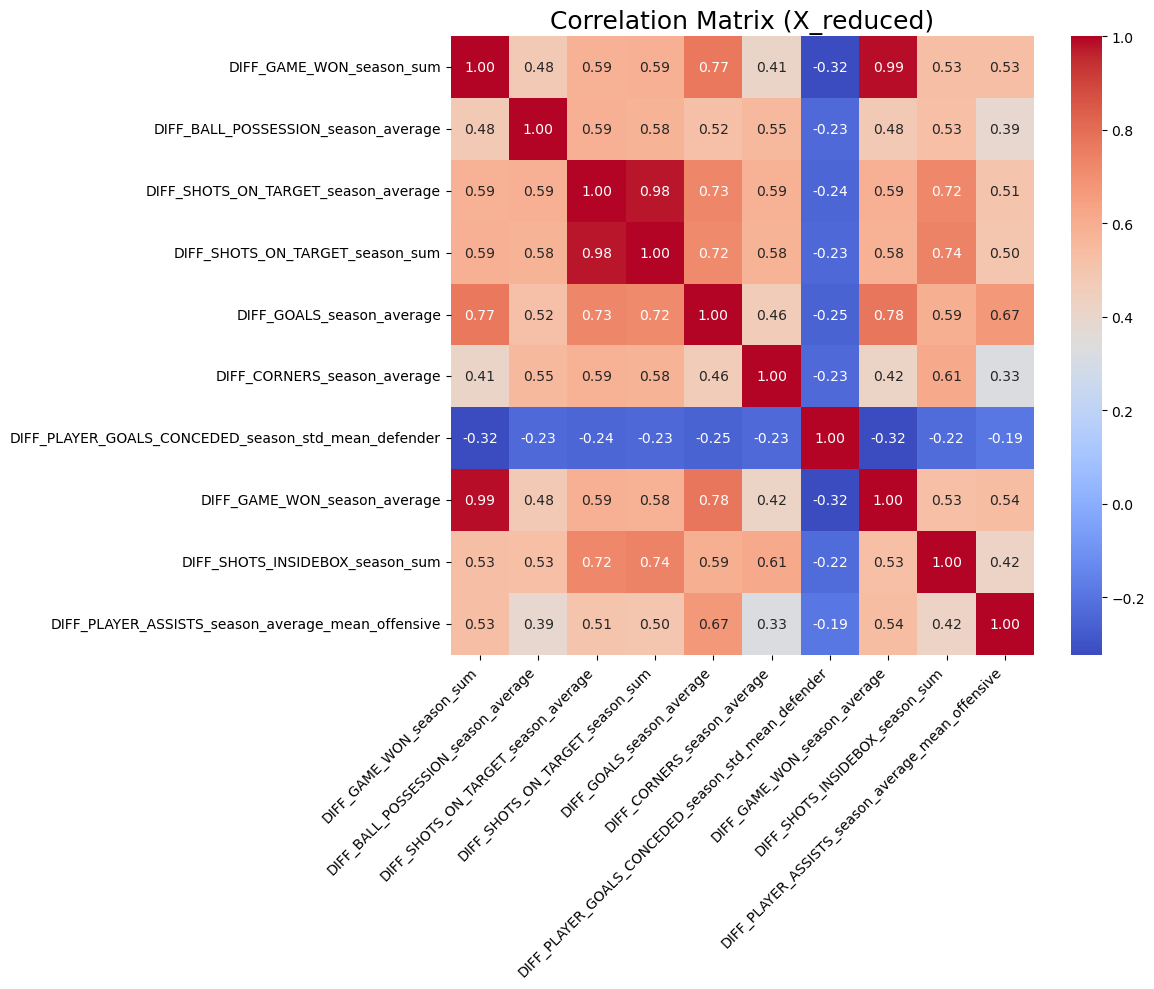

In [18]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

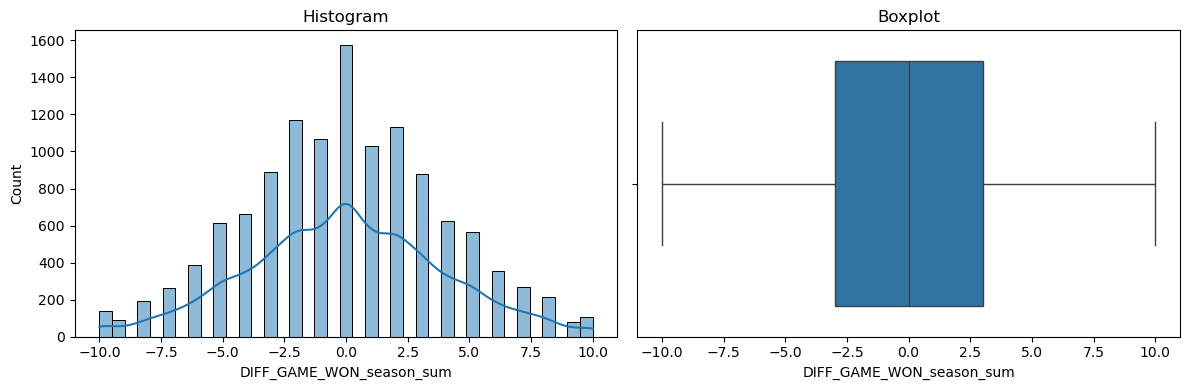

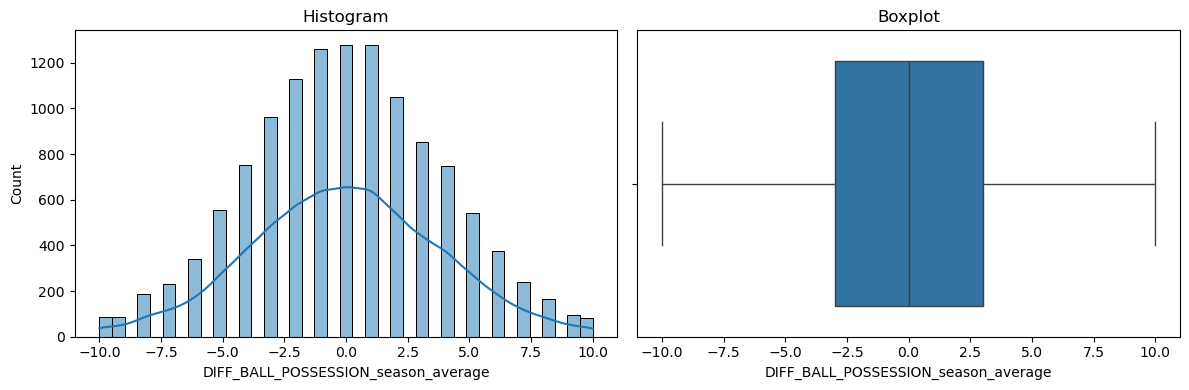

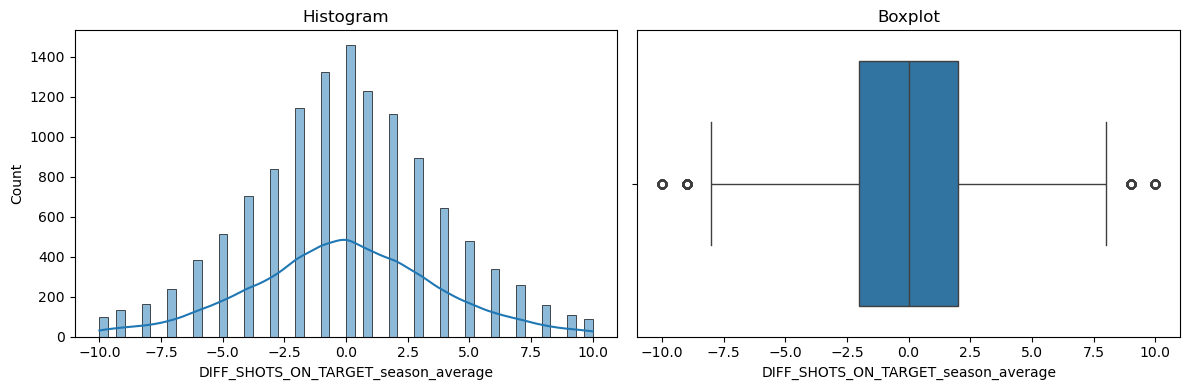

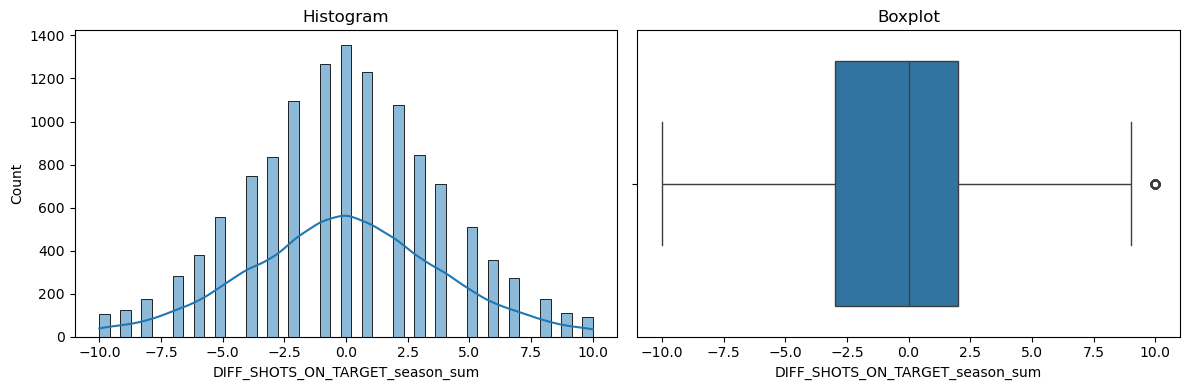

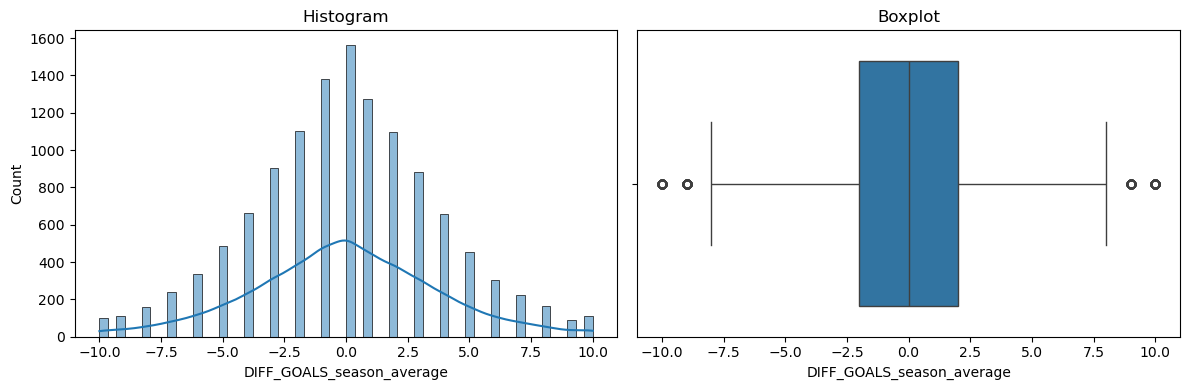

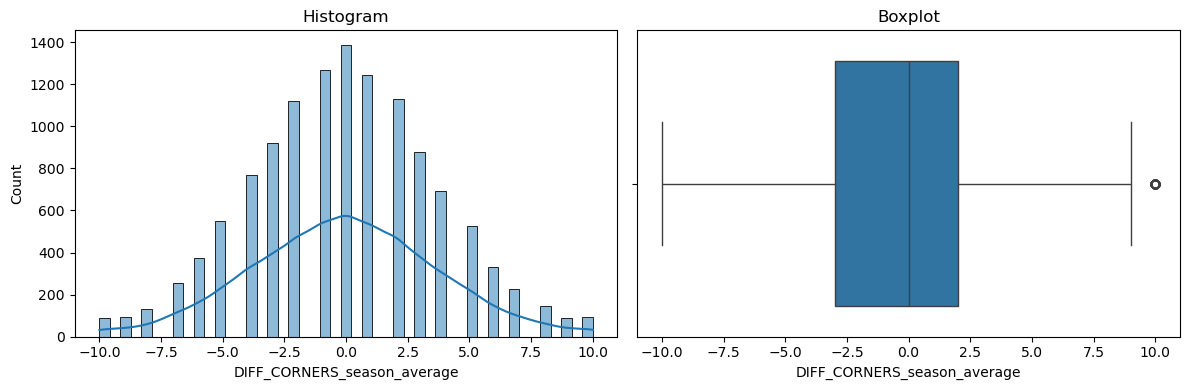

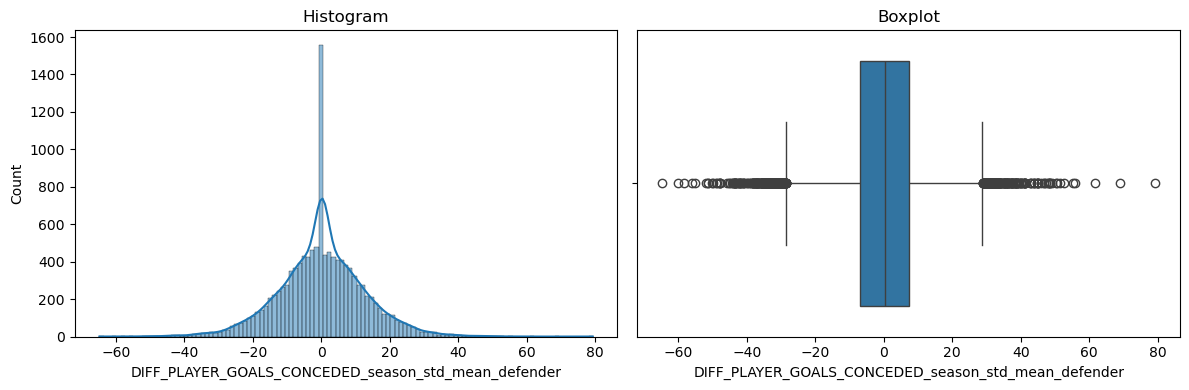

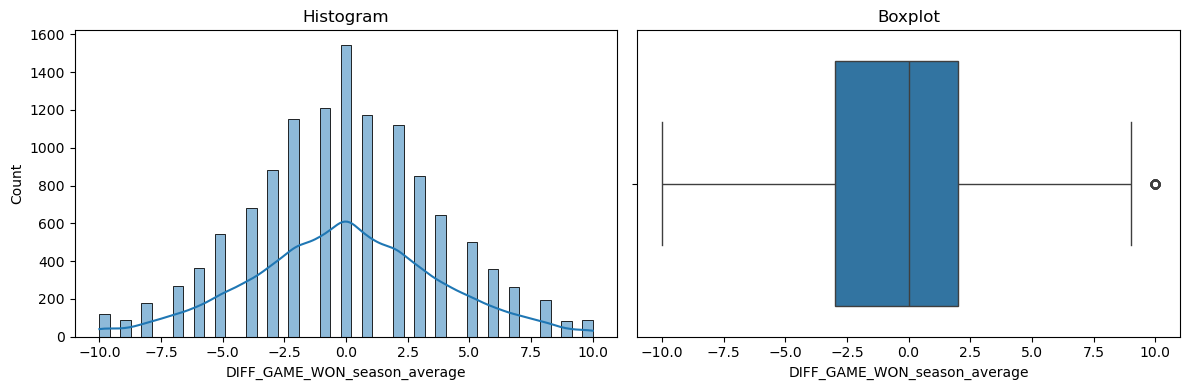

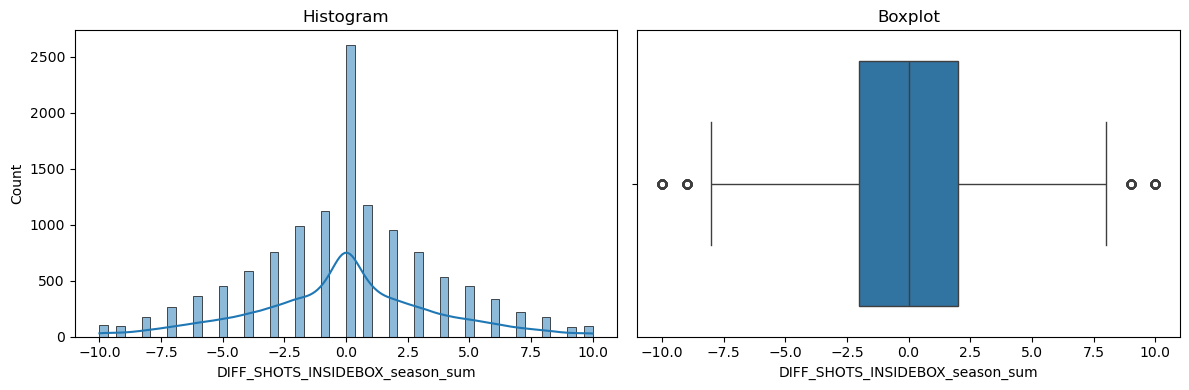

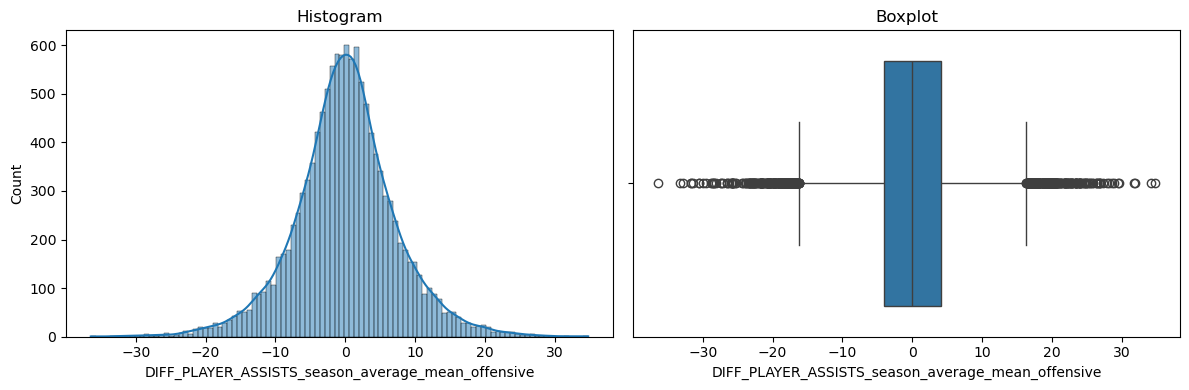

In [19]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)